# はじめに

このノートではLightGBMを理解するために、LightGBMと同じくらい使用頻度の高いXGboostのアルゴリズムについても理解を深めておく。LightGBMの特徴については別のノートで取り上げる予定ではあるが、XGboostの利点を多く備えているのがLightGBMでもあるので、まずはXGboostを理解する。下記のmeanxaiの動画を参考にしている。

- [[MXML-11-01] Extreme Gradient Boosting (XGBoost) [1/9] - Regression: Training & Prediction process - YouTube](https://www.youtube.com/watch?v=mA3uJyMB4XU&list=PLgaemU2xZlTieGRRTAdDlHOgxr-bs6pfr&index=16)
- [[MXML-11-02] Extreme Gradient Boosting (XGBoost) [2/9] - Regression: Algorithm analysis - YouTube](https://www.youtube.com/watch?v=9JeC_-BcbeA&list=PLgaemU2xZlTieGRRTAdDlHOgxr-bs6pfr&index=14)
- [[MXML-11-03] Extreme Gradient Boosting (XGBoost) [3/9] - Implementation of regression from scratch - YouTube](https://www.youtube.com/watch?v=Ms_xxQFrTWc&list=PLgaemU2xZlTieGRRTAdDlHOgxr-bs6pfr&index=13)

今回はXGboostのアルゴリズムを理解し、実際に実装することを目的にする。

## XGboostのアルゴリズム

前回のノートでは、Similarity Scoreを利用し、大きなGainを得ることが良い分岐になることを学んだ。しかし、なぜSimilarity Scoreが良い分岐に繋がるのか理解できていない。そのため、今回のノートでは、それらの点を注目する。

<img src='./BoostingP1.png'>
<img src='./BoostingP2.png'>
<img src='./BoostingP3.png'>
<img src='./BoostingP4.png'>
<img src='./BoostingP5.png'>

## XGboostを再現する

ここまででXGboostのアルゴリズムを理解できたので、実際にコードに起こして、さらに理解を深めていく。下記を参考にしている。

- [[MXML-11-03] Extreme Gradient Boosting (XGBoost) [3/9] - Implementation of regression from scratch - YouTube](https://www.youtube.com/watch?v=Ms_xxQFrTWc&list=PLgaemU2xZlTieGRRTAdDlHOgxr-bs6pfr&index=13)

### Base Learner

In [3]:
import numpy as np
from collections import Counter
import copy

class MyXGBRegressionTree:
    def __init__(self, max_depth, reg_lambda, prune_gamma):
        self.max_depth = max_depth      # 木の深さ
        self.reg_lambda = reg_lambda    # 正則化の強さ
        self.prune_gamma = prune_gamma  # 剪定の強さ
        self.estimator1 = None          # 木の結果1
        self.estimator2 = None          # 木の結果2
        self.feature    = None          # 特徴量X
        self.residual   = None          # 残差
        self.base_score = None          # 初期予測値y0

    # Exact Greedy Algorithm
    # この関数は親ノードを子ノードに分割する
    # did: data point
    def node_split(self, did):
        r = self.reg_lambda
        max_gain = -np.inf
        d = self.feature.shape[1]      # 特徴量次元
        G = -self.residual[did].sum()  # マイナス符号の残差の合計(テイラー展開の2次近似の1回微分)
        H = did.shape[0]               # 残差の数(テイラー展開の2次近似の2回微分)
        p_score = (G ** 2) / (H + r)   # 類似度スコア

        # 特徴量が複数個ある場合に各特徴量を探索する
        for k in range(d):
            GL = HL = 0.0
            x_feat = self.feature[did, k]
            # 重複を除外し、並び替えを行う。unique()が昇順で並び替える。
            x_uniq = np.unique(x_feat)
            # 隣接する値の平均を計算することで、間となる分割点を計算する
            s_point = [np.mean([x_uniq[i - 1], x_uniq[i]]) for i in range(1, len(x_uniq))]
            # 初期値の下限は無限大
            l_bound = -np.inf  
            # 分割点をループする
            for j in s_point:
                # 分割点を基準にデータを左右の葉に振り分ける
                left  = did[np.where(np.logical_and(x_feat > l_bound, x_feat <= j))[0]]
                right = did[np.where(x_feat > j)[0]]

                # 分岐後に左右の葉のHとGを計算する
                GL -= self.residual[left].sum()
                HL += left.shape[0]
                GR = G - GL
                HR = H - HL
                # Gainを計算する
                gain = (GL ** 2) / (HL + r) + (GR ** 2) / (HR + r) - p_score
                # Gainが最大となる分割点を探す
                if gain > max_gain:
                    max_gain = gain
                    b_fid   = k  # ベストな特徴量のid(x1,x2,...,xn)
                    b_point = j  # ベストな特徴量の分割点
                l_bound = j

            # 剪定基準γ以上のGainの場合
            if max_gain >= self.prune_gamma:
                # ベストな分割点を用いて、分割する
                x_feat  = self.feature[did, b_fid]
                b_left  = did[np.where(x_feat <= b_point)[0]]
                b_right = did[np.where(x_feat  > b_point)[0]]
                return {'fid': b_fid, 'split_point': b_point, 'left': b_left, 'right': b_right, 'gain': max_gain}
            else:
                return np.nan  # 分割しない場合はnanを返す

    # 分岐を再帰的に実行する関数
    # nodeと現在の深さが渡される
    def recursive_split(self, node, curr_depth):
        # node_splitのreturnから情報を取得
        left = node['left']
        right = node['right']
        # 再帰の終了条件
        if curr_depth >= self.max_depth:
            return

        # 再帰を実行する
        s = self.node_split(left)
        # node_splitのreturnの状態を調べる。分岐すると辞書型に変更される
        if isinstance(s, dict):  
            node['left'] = s
            # 再帰的に実行する
            self.recursive_split(node['left'], curr_depth + 1)

        s = self.node_split(right)
        if isinstance(s, dict):  # split
            node['right'] = s
            self.recursive_split(node['right'], curr_depth + 1)

    # 葉のアウトプットを計算する関数
    def output_value(self, did):
        r = self.residual[did]
        return np.sum(r) / (did.shape[0] + self.reg_lambda)

    # 木の各葉ごとにアウトプット(w_j)を計算する
    # 葉に到達するまで再帰的に実行し、葉に到達したときにoutput_value()関数で計算する
    def output_leaf(self, d):
        if isinstance(d, dict):
            for key, value in d.items():
                if key == 'left' or key == 'right':
                    rtn = self.output_leaf(value)
                    if rtn[0] == 1:  
                        d[key] = rtn[1]
            return 0, 0 
        else:  
            return 1, self.output_value(d)  

    # 学習データを使って木を作り、その結果を返す(x : 特徴量, y: 残差)
    def fit(self, x, y):
        self.feature = x
        self.residual = y
        self.base_score = y.mean()  # 最初の予測は平均値
        # データ全体が左右のノードに分割される
        # root={'fid': value, 'split_point': value, 'left': value or dict, 'right': value or dict}
        root = self.node_split(np.arange(x.shape[0]))
        if isinstance(root, dict):
            self.recursive_split(root, curr_depth=1)

        # 結果を保存する
        self.estimator1 = root
        # 各葉の結果を保存する
        if isinstance(self.estimator1, dict):
            self.estimator2 = copy.deepcopy(self.estimator1)
            self.output_leaf(self.estimator2)  

        return self.estimator2

    # テストデータのyを予測する関数
    # テストデータポイントが属する葉を検索し、その葉の出力を返す
    # x: 1つのデータ, p: estimator2の結果
    def x_predict(self, p, x):
        # 特徴量IDに対応するデータポイントが分割店よりも小さい場合、木の左に移動
        if x[p['fid']] <= p['split_point']:
            # 葉ではない場合、再帰的に移動する
            if isinstance(p['left'], dict):  
                return self.x_predict(p['left'], x)
            else:  # leaf
                return p['left']
        else:
            if isinstance(p['right'], dict): 
                return self.x_predict(p['right'], x)
            else: 
                return p['right']

    # テストデータのxすべてを予測する
    def predict(self, x_test):
        p = self.estimator2  # predictor
        if isinstance(p, dict):
            y_pred = [self.x_predict(p, x) for x in x_test]
            return np.array(y_pred)
        else:
            return np.array([self.base_score] * x_test.shape[0])



### XGBoost回帰


In [4]:
class MyXGBRegressor:
    def __init__(self, n_estimators=10, max_depth=3, learning_rate=0.3, prune_gamma=2.0, reg_lambda=0.0, base_score=0.5):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.eta = learning_rate        # 学習率
        self.prune_gamma = prune_gamma  # 剪定の強さ
        self.reg_lambda = reg_lambda    # 正則化の強さ
        self.base_score = base_score    # 初期予測値
        self.estimator1 = dict()        # tree result-1
        self.estimator2 = dict()        # tree result-2
        self.models = []
        self.loss = []

    # The same as GBM algorithm. In XGBoost, only the node
    # splitting method changes.
    def fit(self, x, y):
        # step-1: 初期予測値で初期化
        Fm = self.base_score
        self.models = []
        self.loss = []

        for m in range(self.n_estimators):
            # step-2 (A): 疑似残差を計算
            residual = y - Fm
            # step-2 (B): 残差に回帰を実行する
            model = MyXGBRegressionTree(
                max_depth=self.max_depth, 
                reg_lambda=self.reg_lambda,
                prune_gamma=self.prune_gamma
                )
            model.fit(x, residual)
            # step-2 (C): テストデータを予測する
            gamma = model.predict(x)
            # step-2 (D): 予測値を更新する
            Fm = Fm + self.eta * gamma
            # ツリーモデルを保存
            self.models.append(model)
            # MSEを計算
            self.loss.append(((y - Fm) ** 2).sum())
        return self.loss

    def predict(self, x_test):
        y_pred = np.zeros(shape=(x_test.shape[0],)) + self.base_score
        for model in self.models:
            y_pred += self.eta * model.predict(x_test)
        return y_pred


### Generate Sample Data

In [5]:
# データ生成用の関数
def nonlinear_data(n, s):
    rtn_x, rtn_y = [], []
    for i in range(n):
        x = np.random.random()
        y = 2.6 * np.sin(2.0 * np.pi * x) + np.random.normal(0.0, s) + 3.0
        rtn_x.append(x)
        rtn_y.append(y)
    return np.array(rtn_x).reshape(-1, 1), np.array(rtn_y)

X, y = nonlinear_data(n=300, s=0.5)

# 可視化用の関数
def plot_prediction(x, y, x_test, y_pred_my_model, y_pred_xg_model):
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, c='gray', s=20, alpha=0.5, label="train data")
    plt.plot(x_test, y_pred_my_model, c='tomato', lw=2.0, label='My XGBRegressor prediction')
    plt.plot(x_test, y_pred_xg_model, c='royalblue', lw=2.0, label='XGBRegressor prediction')
    plt.xlim(0, 1)
    plt.ylim(0, 7)
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Training data and predictions')
    plt.show()



### Run the model

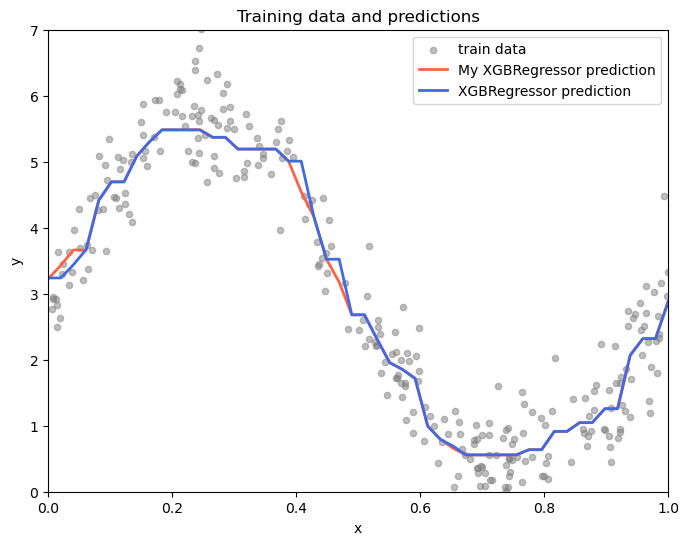

In [6]:
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

y_mean = y.mean()  # 初期値
n_depth = 3        # 木の深さ
n_tree = 20        # 木の数
eta = 0.3          # 学習率
reg_lambda = 1.0   # 正則化の強さ
prune_gamma = 2.0  # 剪定の強さ

my_model = MyXGBRegressor(
    n_estimators=n_tree, 
    max_depth=n_depth, 
    learning_rate=eta, 
    prune_gamma=prune_gamma,
    reg_lambda=reg_lambda, 
    base_score=y_mean
)

my_model.fit(X, y)

# xgboostライブラリ
xg_model = XGBRegressor(
    n_estimators=n_tree, 
    max_depth=n_depth, 
    learning_rate=eta, 
    gamma=prune_gamma,
    reg_lambda=reg_lambda, 
    base_score=y_mean
)

xg_model.fit(X, y)

# 予測用のテストデータを作成
x_test = np.linspace(0, 1, 50).reshape(-1, 1)

# 自作モデルとxgboostライブラリのモデルで予測
y_pred_my_model = my_model.predict(x_test)
y_pred_xg_model = xg_model.predict(x_test)

# トレーニングデータと予測結果をプロット
plot_prediction(X, y, x_test, y_pred_my_model, y_pred_xg_model)